[Ref](https://www.analyticsvidhya.com/blog/2021/05/how-to-create-a-stroke-prediction-model/)

# Importing libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score,classification_report,precision_score,recall_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Reading CSV

In [7]:
data = pd.read_csv('../data/stroke.csv')

data.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [8]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [9]:
data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


# EDA

## ID
ID dùng để định danh người bệnh, ở đây không có nhiều ý nghĩa nên ta xóa cột này

In [10]:
data.drop('id', inplace=True, axis=1)

## Gender


In [11]:
data['gender'].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [12]:
data['gender'].replace('Other', list(data['gender'].mode().values)[0], inplace=True)
data['gender'].value_counts()

Female    2995
Male      2115
Name: gender, dtype: int64

<AxesSubplot:xlabel='gender', ylabel='count'>

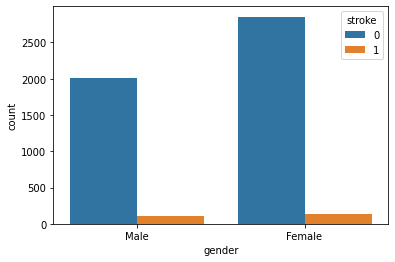

In [13]:
sns.countplot(data=data, x='gender', hue='stroke')

Quan sát thấy bộ dữ liệu đang mất cân bằng. Tuy nhiên không có sự khác biệt nhiều giữa tỉ lệ người bị đột quỵ giữa 2 giới tính.

## Age

Tuổi là yếu tố quan trọng vì có thể là biến ảnh hưởng nhiều đến kết quả dự đoán sau này.

In [14]:
data['age'].nunique()

104

<Figure size 1152x576 with 0 Axes>

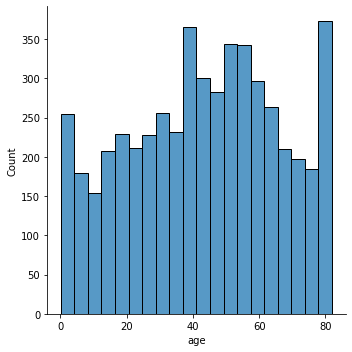

<Figure size 1152x576 with 0 Axes>

In [15]:
sns.displot(data['age'])
plt.figure(figsize=(16,8))

<AxesSubplot:xlabel='stroke', ylabel='age'>

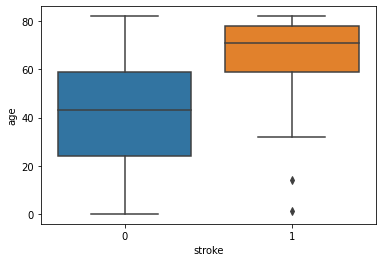

In [16]:
sns.boxplot(data=data, x='stroke', y='age')


Quan sát: Những người ở độ tuổi >60 có nguy cơ bị đột quỵ cao hơn. Có 1 vài outlier là những người ở độ tuổi 20 bị đột quỵ, có thể coi là dữ liệu hợp lệ vì đột quỵ còn phụ thuộc vào lối sống và cách ăn uống. Những người không bị đột quỵ đều trong độ tuổi từ 20 - dưới 60 - điều này cũng khá dễ hiểu.

## Hypertension


In [17]:
data['hypertension'].value_counts()

0    4612
1     498
Name: hypertension, dtype: int64

<AxesSubplot:xlabel='age', ylabel='count'>

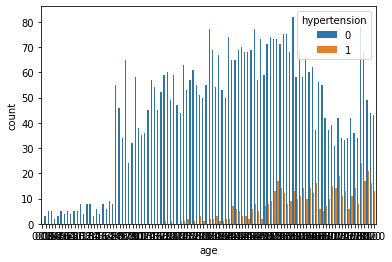

In [18]:
sns.countplot(data=data, x='age', hue='hypertension')

<AxesSubplot:xlabel='hypertension', ylabel='count'>

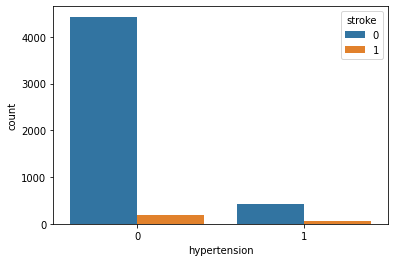

In [19]:
sns.countplot(data=data, x='hypertension', hue='stroke')

Quan sát thấy cao huyết áp hiếm khi xảy ra ở người trẻ, xảy ra thường xuyên hơn ở người có tuổi. Cao huyết áp có thể gây đột quỵ, tuy nhiên dữ liệu bị đột quỵ khá ít nên cũng không rõ ràng lắm giữa việc bị cao huyết áp và đột quỵ

## Heart disease

In [20]:
data['heart_disease'].value_counts()

0    4834
1     276
Name: heart_disease, dtype: int64

<AxesSubplot:xlabel='heart_disease', ylabel='count'>

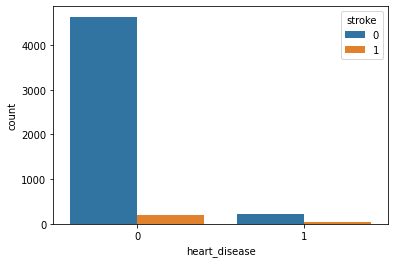

In [21]:
sns.countplot(data=data, x='heart_disease', hue='stroke')

Vì dữ liệu đang mất cân bằng khá nhiều, nhận định thực tế thì có thể thấy những người bị bệnh về tim có khả năng cao bị đột quỵ tuy nhiên qua biều đồ ta không thấy bệnh tim có ảnh hưởng đến việc bị đột quỵ.

## Ever married

In [22]:
data['ever_married'].value_counts()

Yes    3353
No     1757
Name: ever_married, dtype: int64

<AxesSubplot:xlabel='ever_married', ylabel='count'>

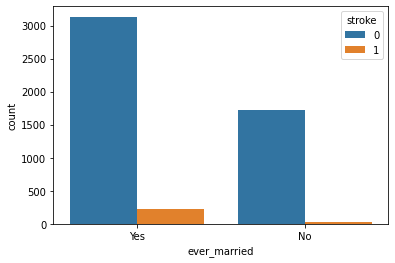

In [23]:
sns.countplot(data=data, x='ever_married', hue='stroke')

Những người đã kết hôn có tỉ lệ bị đột quỵ cao hơn chưa kết hôn.

## Work Type

Những công việc khác nhau có những vấn đề và thách thức khác nhau, đây có thể là lý do gây phấn khích, căng thẳng, hồi hộp... Căng thẳng không tốt cho sức khỏe, ta thử phân tích xem sao.

In [24]:
data['work_type'].value_counts()

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

<AxesSubplot:xlabel='work_type', ylabel='count'>

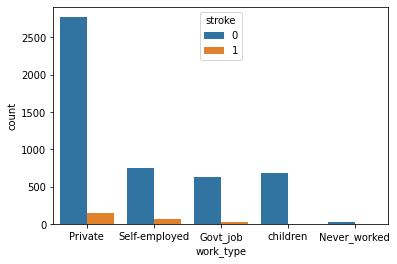

In [25]:
sns.countplot(data=data,x='work_type',hue='stroke')

Quan sát thấy những người làm công việc Private có tỉ lệ đột quỵ cao hơn các loại công việc khác. Những người chưa từng làm việc có tỉ lệ bị đột quỵ rất thấp.

## Residence Type

In [26]:
data['Residence_type'].value_counts()

Urban    2596
Rural    2514
Name: Residence_type, dtype: int64

<AxesSubplot:xlabel='Residence_type', ylabel='count'>

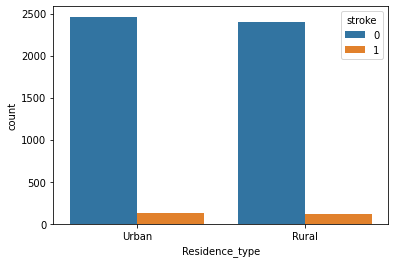

In [27]:
sns.countplot(data=data,x='Residence_type',hue='stroke')

Quan sát thấy các loại Residence Type khác nhau không có chênh lệch nhiều về tỉ lệ đột quỵ. Ta có thể bỏ bớt biến này.

## Average Glucose Level

In [28]:
data['avg_glucose_level'].nunique()

3979

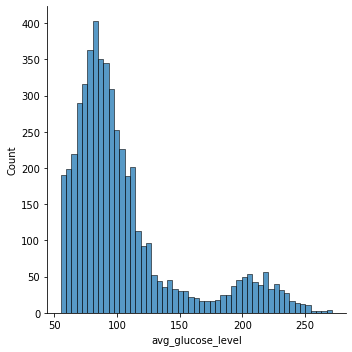

In [29]:
sns.displot(data['avg_glucose_level'])

<AxesSubplot:xlabel='stroke', ylabel='avg_glucose_level'>

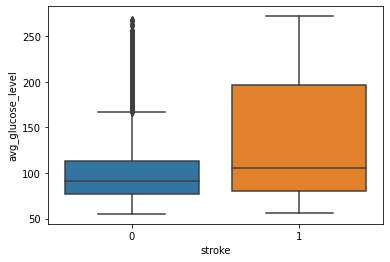

In [30]:
sns.boxplot(data=data,x='stroke',y='avg_glucose_level')

Theo biểu đồ bên trên, ta có thể thấy những người bị đột quỵ có mức độ đường huyết trung bình là 100. Có khá nhiều outliers bệnh nhân không bị đột quỵ

## BMI

In [31]:
data['bmi'].isna().sum()

201

In [32]:
data['bmi'].fillna(data['bmi'].mean(),inplace=True)

In [33]:
data['bmi'].nunique()

419

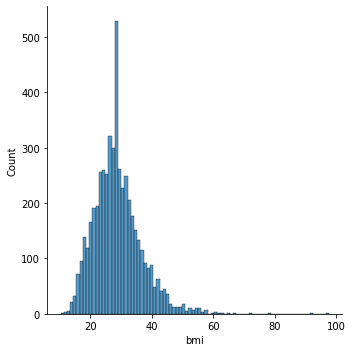

In [34]:
sns.displot(data['bmi'])

<AxesSubplot:xlabel='stroke', ylabel='bmi'>

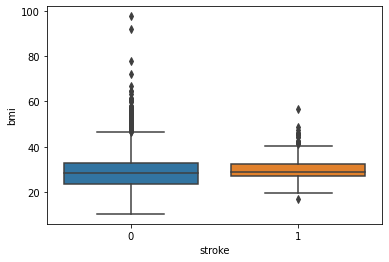

In [35]:
sns.boxplot(data=data,x='stroke',y='bmi')

Qua biểu đồ ta không thấy khác biệt rõ ràng việc ảnh hưởng của BMI đến khả năng bị đột quỵ.

## Smoking Status

In [36]:
data['smoking_status'].value_counts()

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

<AxesSubplot:xlabel='smoking_status', ylabel='count'>

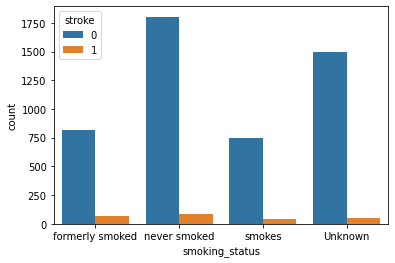

In [37]:
sns.countplot(data=data,x='smoking_status',hue='stroke')

Quan sát không thấy có quá nhiều khác biệt giữa tỉ lệ bị đột quỵ với trạng thái hút thuốc.

## Stroke

In [38]:
data['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

<AxesSubplot:xlabel='stroke', ylabel='count'>

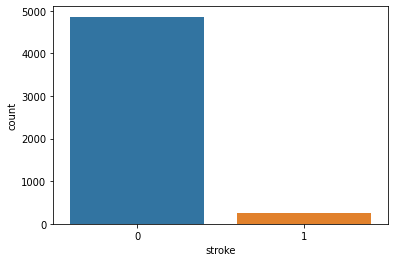

In [39]:
sns.countplot(data=data,x='stroke')

Dữ liệu mất cân bằng, chỉ có 249/5110 bệnh nhận bị đột quỵ

# Feature engineering

## Label encoding

Bộ dữ liệu chứa cả biến định tính và định lượng, các thuật toán ML chỉ hiểu dữ liệu ở dạng số, nên ta cần chuyển các biến định tính này về định lượng thông qua LabelEncoder - nó sẽ lấy giá trị theo thứ tự giảm dần và đổi nó sang kiểu số.

In [40]:
cols=data.select_dtypes(include=['object']).columns
print(cols)

Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object')


In [41]:
le = LabelEncoder()
data[cols] = data[cols].apply(le.fit_transform)

data.head(5)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.600000,1,1
1,0,61.0,0,0,1,3,0,202.21,28.893237,2,1
2,1,80.0,0,1,1,2,0,105.92,32.500000,2,1
3,0,49.0,0,0,1,2,1,171.23,34.400000,3,1
4,0,79.0,1,0,1,3,0,174.12,24.000000,2,1


## Correlation

<AxesSubplot:>

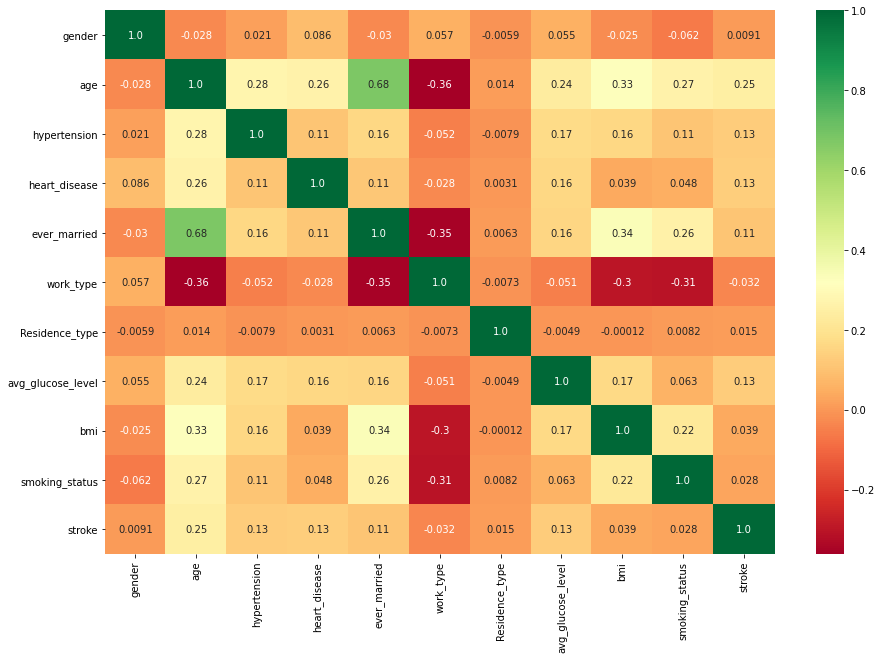

In [42]:
plt.figure(figsize=(15,10))
sns.heatmap(data.corr(), annot=True, fmt='.2', cmap = 'RdYlGn')

Quan sát thấy các biến độc lập có tương quan với biến phụ thuộc là: age, hypertension, heart_disease, ever_married, avg_glucose_level 

In [43]:
classifier = SelectKBest(score_func=f_classif,k=5)
fits = classifier.fit(data.drop('stroke',axis=1),data['stroke'])
x=pd.DataFrame(fits.scores_)
columns = pd.DataFrame(data.drop('stroke',axis=1).columns)
fscores = pd.concat([columns,x],axis=1)
fscores.columns = ['Attribute','Score']
fscores.sort_values(by='Score',ascending=False)

,Attribute,Score
1,age,326.916568
3,heart_disease,94.698406
7,avg_glucose_level,90.503870
2,hypertension,84.953542
4,ever_married,60.667230
8,bmi,7.759776
5,work_type,5.340019
9,smoking_status,4.043033
6,Residence_type,1.220842
0,gender,0.424625


In [44]:
cols=fscores[fscores['Score']>50]['Attribute']
cols

1                  age
2         hypertension
3        heart_disease
4         ever_married
7    avg_glucose_level
Name: Attribute, dtype: object

## Splitting data

In [45]:
train_x,test_x,train_y,test_y=train_test_split(data[cols],data['stroke'],random_state=1255,test_size=0.2)
#Splitting data
train_x.shape,test_x.shape,train_y.shape,test_y.shape

((4088, 5), (1022, 5), (4088,), (1022,))

## Balancing dataset

Dữ liệu của chúng ta bị mất cân bằng. Nên ta cần cân bằng lại dữ liệu. Ta sẽ sử dụng phương thức SMOTE. Phương thức này sẽ phân bố dữ liệu của chúng ta với các bản ghi tương đồng với các lớp thiểu số. Bình thường ta sẽ thực hiện trên toàn tập dữ liệu, tuy nhiên bộ dữ liệu này có rất ít dữ liệu thuộc lớp thiểu số (minor) nên ta sẽ áp dụng trên cả tập train và test. Đã thử trên tập train nhưng hiệu quả không tốt, nên thử trên cách tiếp cận này cho kết quả tốt hơn.

In [46]:
smote = SMOTE()
train_x, train_y = smote.fit_resample(train_x, train_y)
test_x, test_y = smote.fit_resample(test_x, test_y)

In [47]:
train_x.shape,train_y.shape,test_x.shape,test_y.shape

((7778, 5), (7778,), (1944, 5), (1944,))

In [48]:
df_y_train = pd.DataFrame({'stroke': train_y.values})
df_y_train.head()

,stroke
0,0
1,0
2,1
3,0
4,1


<AxesSubplot:xlabel='stroke', ylabel='count'>

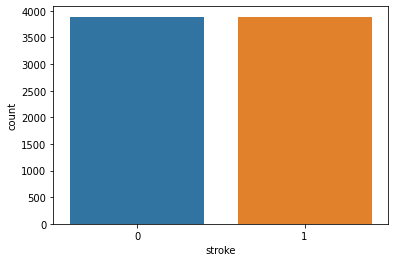

In [49]:
sns.countplot(data=df_y_train, x='stroke')

In [50]:
from sklearn.cluster import KMeans
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

sse = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(train_x)
    sse.append(kmeans.inertia_)

In [53]:
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.600000,1,1
1,0,61.0,0,0,1,3,0,202.21,28.893237,2,1
2,1,80.0,0,1,1,2,0,105.92,32.500000,2,1
3,0,49.0,0,0,1,2,1,171.23,34.400000,3,1
4,0,79.0,1,0,1,3,0,174.12,24.000000,2,1


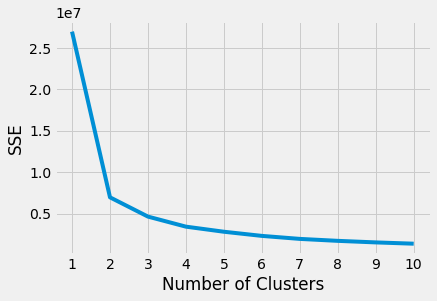

In [51]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [52]:
from kneed import KneeLocator
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")

kl.elbow

2